# Particle Monitor: WR75 study case
In this script, we showcase how the particle monitor data from CST can be treated. Source `.cst` file for the electromagnetic and PIC solvers are provided.

In [1]:
from pathlib import Path
import random

import vedo

from simultipac.particle_monitor.particle_monitor import ParticleMonitor
from simultipac.particle_monitor.studies import plot_emission_energies, plot_collision_energies, plot_collision_angles
from simultipac.particle_monitor.studies import plot_collision_energies
from simultipac.visualization.plot_3d import plot_structure_and_some_trajectories

# To output interactive 3d in .html (needs k3d library):
vedo.settings.default_backend= 'k3d'
# would be the best but plotting raises error:
# TraitError: The 'point_size' trait of a Points instance expected a float or a dict, not the float64 0.0.

# To output interactive 3d that does not appear in .html:
vedo.settings.default_backend= 'vtk'

# To output non-interactive 2d only, but that creates an image in .html:
vedo.settings.default_backend= '2d'

[INFO    ] [log_manager.py      ] Starting log for Simultipac - Version: 2.0.1.dev22+g1f37471.d20250203, Commit: 4b5d5ef2b86b4dfcf4d980bfb8595196269c8775


## Loading files
First of all, we define the paths to the folder with all the `.txt` file produced by CST, as well as the character that separates the columns in the file.

In [2]:
example_data = Path("..", "data", "cst")
folder, delimiter = Path(example_data, "WR75_reduced", "Export", "3d"), None

Now we load the particles. This operation will take a while, as there are a lot of files.

In [3]:
my_particle_monitor = ParticleMonitor.from_folder(folder, delimiter=delimiter)

/home/placais/Documents/simulation/python/simultipac/src/simultipac/particle_monitor/vector.py:140: RankWarning: Polyfit may be poorly conditioned
  polynom = np.polyfit(


The warning is raised during the extrapolation of the position and momentum arrays (used to detect collision with the mesh). It is raised because the distance crossed by the particles between two position monitor files is too high.
Typically, I generally save 20 files per RF period. Here I just wanted the files to be light enough, hence the low resolution.

## Plotting emission energies

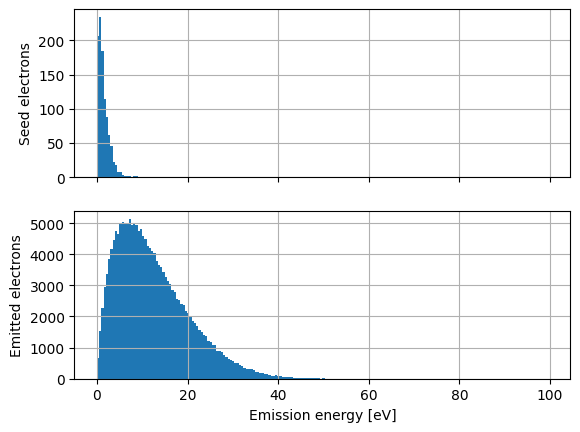

In [4]:
bins = 200  # Number of histogram bins
hist_range = (0., 1e2)  # Range of the histogram
fig = plot_emission_energies(my_particle_monitor, bins=bins, hist_range=hist_range)

## Plotting collision energies
To plot the distribution of the collision energies, the syntax is very similar.

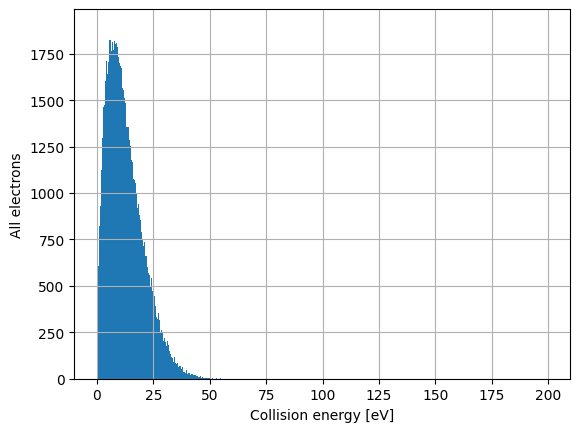

In [5]:
bins = 1000
hist_range = (0., 2e2)
fig = plot_collision_energies(my_particle_monitor, bins=bins, hist_range=hist_range)

## Plotting impact angles
We can also plot an histogram of the impact angles. This is a little bit more complex, as it depends on the geometry of the system. From CST, we export it as a `.stl` file. Then we load it using the `vedo` library.
To check if the resolution of the file or the units math the ones of the particle monitor, look at "Plotting trajectories" a few cells below.

In [6]:
stl_file = Path(example_data, "WR75_reduced", "wr75.stl")
my_mesh = vedo.load(str(stl_file))

We reduce the opacity of the waveguide to 30% to see inside. For full list of what you can see `vedo`, see https://vedo.embl.es/docs/vedo.html.


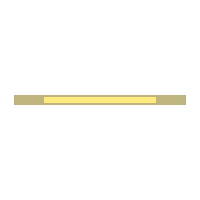

In [7]:
my_mesh.alpha(0.3)

In contrary to `Particle.emission_energy` or `Particle.collision_energy`, we cannot just call `Particle.collision_angle`; we must compute it first.

In [8]:
my_particle_monitor.compute_collision_angles(my_mesh,
                                             warn_multiple_collisions=False,
                                             warn_no_collision=True)

/home/placais/Documents/simulation/python/simultipac/src/simultipac/particle_monitor/particle.py:334: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.collision_angle = abs(math.atan(tan_theta))


[INFO    ] [particle.py         ] No collision for particle 56121.


Collision angles are computed thanks to the extrapolated position. Here, the extrapolated position is outside of the rectangular waveguide, so the trajectory crosses several cells; we only keep the impacted cell with the lowest ID, which is not very very rigorous. Will be changed in a latter update.

Now we can plot the distribution of the impact energies!

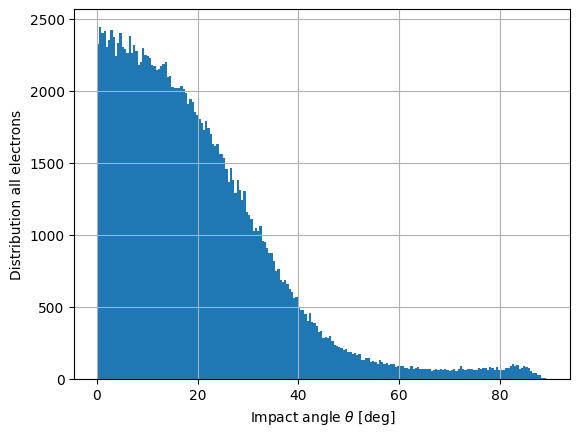

In [9]:
bins = 200
hist_range = (0., 90.)
fig = plot_collision_angles(my_particle_monitor, bins=bins, hist_range=hist_range)

## Plotting the trajectories

We can also plot some trajectories. First of all, we define `pid_to_plot`, a list of integers which correspond to the identifier (`pid`) of the particle to plot. Here, we will plot the trajectories of 15 random particles.

In [10]:
number_of_particles_to_plot = 15
pid_to_plot = random.sample(list(my_particle_monitor.keys()), number_of_particles_to_plot)

veplot1 = vedo.Plotter()
lines, points = plot_structure_and_some_trajectories(my_particle_monitor,
                                              pid_to_plot,
                                              add_extrapolated_position=False)
veplot1 += [my_mesh, lines, points]

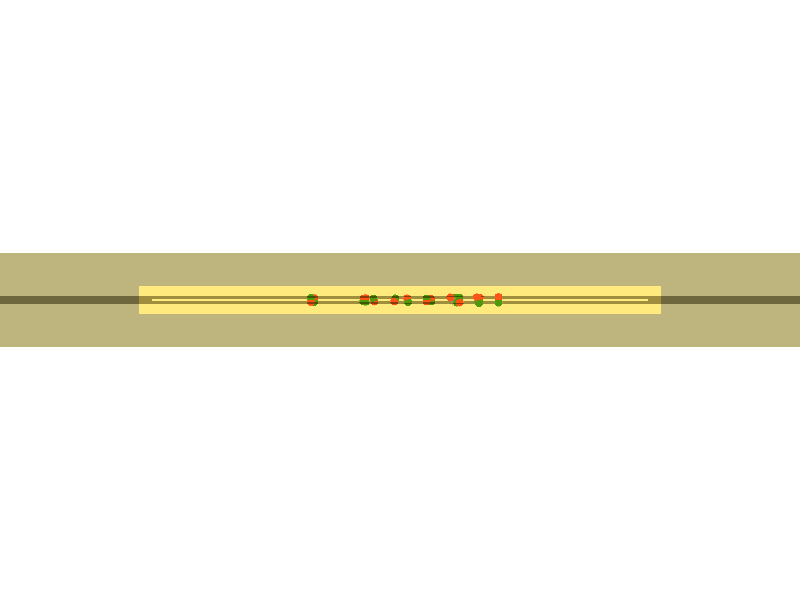

In [11]:
veplot1.show()

In this plot, the emission points are in blue. If there is no emission point, it is because the electron you are looking at is a seed electron.
The last known position is in red.
If you want to see the extrapolated position, it will be in green.

# Particle Monitor: TESLA study case
As the gap of the reduced WR75 is very tight, the visualisation of the trajectories is not very impressive. Let's fix that by looking at a TESLA cavity.

## Loading data and making trajectory plot

In [12]:
folder = Path(example_data, "Particle_Monitor", "tesla_no_mp")
my_particle_monitor = ParticleMonitor.from_folder(folder)

stl_file = Path(example_data, "Particle_Monitor", "tesla.stl")
my_mesh = vedo.load(str(stl_file)).alpha(0.3)

number_of_particles_to_plot = 25
pid_to_plot = random.sample(list(my_particle_monitor.keys()), number_of_particles_to_plot)

veplot2 = vedo.Plotter()
lines, points = plot_structure_and_some_trajectories(my_particle_monitor,
                                                     pid_to_plot,
                                                     add_extrapolated_position=False)
veplot2 += [my_mesh, lines, points]

Note that, again, the resolution on the trajectories is low. This may lead to incorrect impact angles.

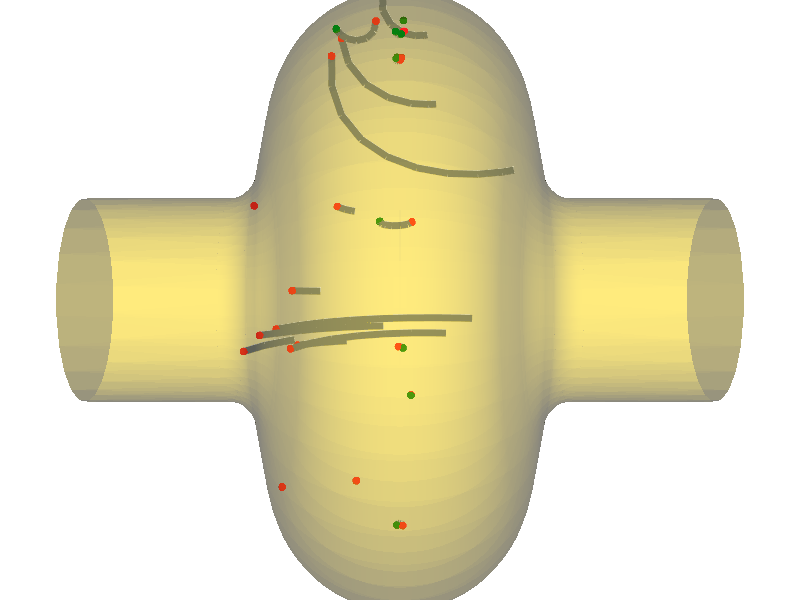

In [13]:
veplot2.show()